(example_4)=
# Example 4: Learning causal coupling

Author contribution: Lina Walkowiak

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

In [194]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark



In [ ]:
%load_ext autoreload
%autoreload 2

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import jit, vjp
from jax.tree_util import Partial
from pyhgf.math import binary_surprise
from pyhgf.model.network import Network
from pyhgf.utils import beliefs_propagation
from pytensor.graph import Apply, Op


np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this notebook, we implement a model that incorporates causal coupling within a HGF. The model takes two time series as input, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 


## Simulating a data set


To simulate the timeseries data, we define blocks with differing causal influence strengths.
We simulate an independent time series, as well as a second time series that is generated based on the influence from time series 1. For each sample, the value of series 2 is a function of those of 1, scaled by the causal influence factor of the given block. 


In [196]:
# Define causal influence strengths for different blocks
influence_strengths = {
    "strong": 0.8,
    "moderate": 0.5,
    "weak": 0.2
}

block_sizes = [50, 50, 50]
causal_influence_sequence = []

# Assign different strengths to each block and create one sequence
causal_influence_sequence.extend([influence_strengths["strong"]] * block_sizes[0])
causal_influence_sequence.extend([influence_strengths["moderate"]] * block_sizes[1])
causal_influence_sequence.extend([influence_strengths["weak"]] * block_sizes[2])
causal_influence_sequence = np.array(causal_influence_sequence)

# Generate series 1 (independently)
n_samples = len(causal_influence_sequence)
series_1 = 10 + np.random.normal(size=n_samples)

# Create the dependent time series 2 based on influences
series_2 = np.zeros(n_samples)
for i in range(n_samples):
    causal_effect = causal_influence_sequence[i]
    series_2[i] = (2 * series_1[i]) * causal_effect + np.random.normal(scale=0.5)

# Or hpw more variablility instead?


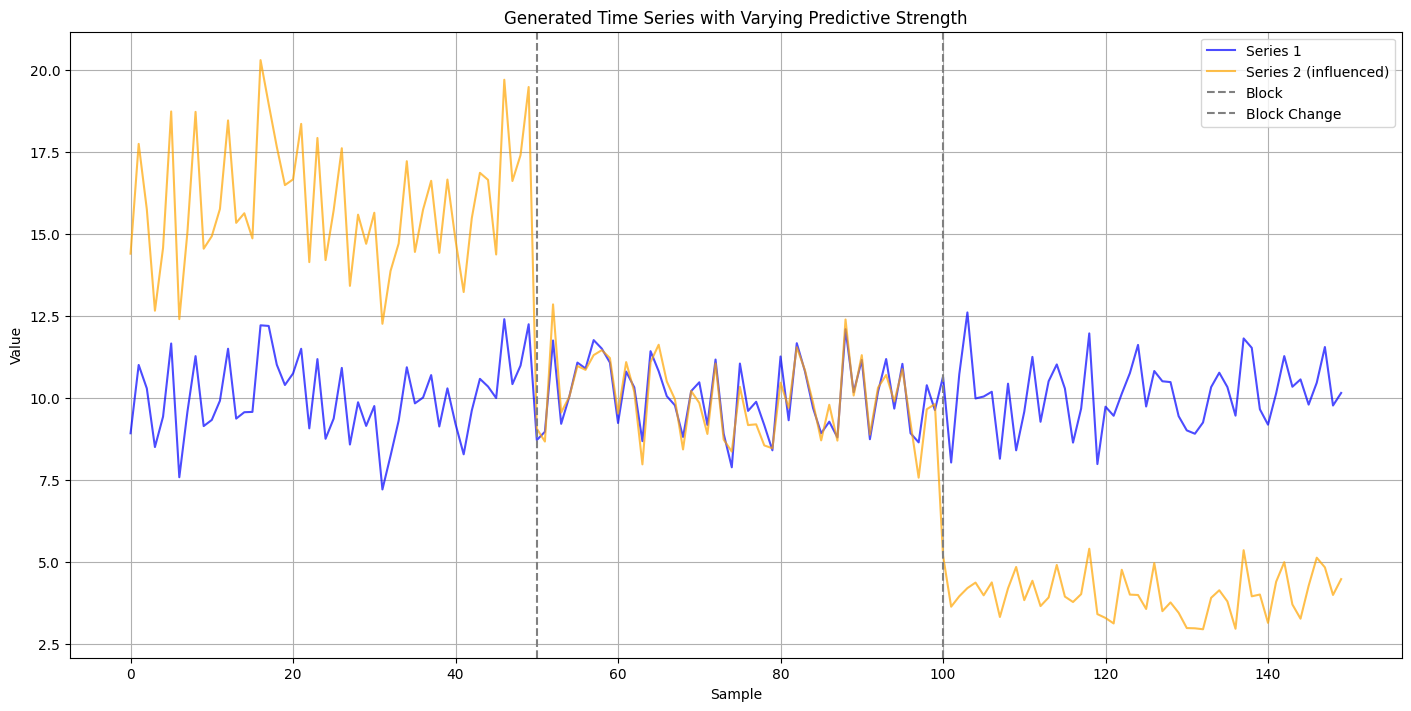

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_42362/3724623571.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


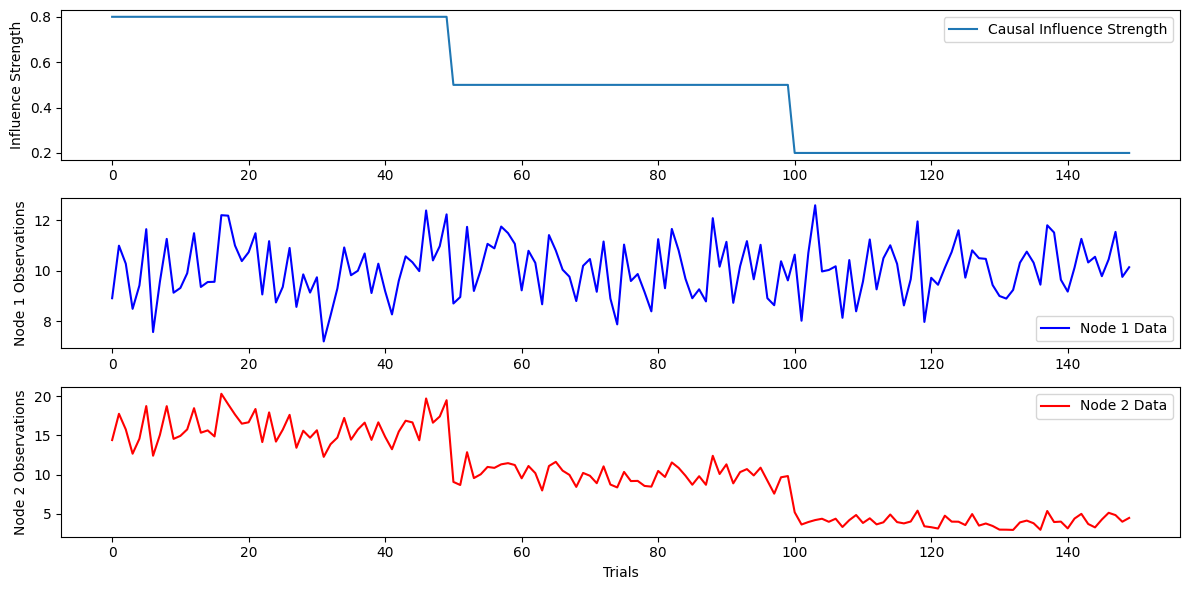

In [197]:
# Plot the results 

# Plot 1
plt.figure(figsize=(14, 7))
plt.plot(series_1, label='Series 1', color='blue', alpha=0.7)
plt.plot(series_2, label='Series 2 (influenced)', color='orange', alpha=0.7)
plt.title('Generated Time Series with Varying Predictive Strength')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.axvline(x=50, color='gray', linestyle='--', label='Block')
plt.axvline(x=100, color='gray', linestyle='--', label='Block Change')
plt.legend()
plt.grid()
plt.show()

# Plot 2
plt.figure(figsize=(12, 6))
# Plot the causal influence over trials
plt.subplot(3, 1, 1)
plt.plot(causal_influence_sequence, label="Causal Influence Strength")
plt.ylabel("Influence Strength")
plt.legend()

# Plot node 1 time series
plt.subplot(3, 1, 2)
plt.plot(series_1, label="Node 1 Data", color="b")
plt.ylabel("Node 1 Observations")
plt.legend()

# Plot node 2 time series
plt.subplot(3, 1, 3)
plt.plot(series_2, label="Node 2 Data", color="r")
plt.ylabel("Node 2 Observations")
plt.legend()

plt.xlabel("Trials")
plt.tight_layout()
plt.show()

# Pack the observations into a matrix format

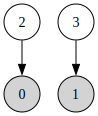

In [199]:
custom_hgf = (
    Network()
    .add_nodes(n_nodes=1, kind="continuous-state", causal_children=1)
    .add_nodes(n_nodes=1, kind="continuous-state", causal_children=0)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)
custom_hgf.plot_network()





## Fitting the model

## System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Oct 31 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.31
jaxlib: 0.4.31

arviz     : 0.20.0
pytensor  : 2.25.5
pandas    : 2.2.3
IPython   : 8.29.0
jax       : 0.4.31
pyhgf     : 0.0.0
matplotlib: 3.9.2
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
seaborn   : 0.13.2
pymc      : 5.17.0
numpy     : 1.26.0

Watermark: 2.5.0

